In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utide import solve
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

In [38]:
from analysis_routines import *
from ploting_routines import *
from processing_routines import datenum_to_epoch
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

### U-Tide

In [148]:
def coef_dataframe(date, value, lat=43.789):
    coef = solve(date, value, lat=lat, nodal=False, verbose=False)
    columns = ['A', 'A_ci', 'g', 'g_ci']
    data_dict = dict((k, coef[k]) for k in ['name', 'A', 'A_ci', 'g', 'g_ci', 'PE', 'SNR'] if k in coef)
    df = pd.DataFrame(data_dict)
    df.insert(1, 'period', 1/coef.aux['frq'])
    return df

In [149]:
temp, pres, date, lat, _ = load_time_series('processed/AGL_20181116_chain.nc', latlon=True)

In [150]:
# trim time series
dn = 12 # get datapoints every 60 seconds, not every 5
n_max = int(timedelta(days=120).total_seconds()/5)
date = date[::dn]
temp = temp[::dn]

In [151]:
df9 = coef_dataframe(date, temp[:, 9])

In [152]:
df_test = df9.copy()

In [153]:
df_test = df_test[df_test['A_ci'] < df_test['A']]

In [154]:
df_test

,name,period,A,A_ci,g,g_ci,PE,SNR
1,M2,12.420601,0.084548,0.014040,22.379450,9.518010,30.171330,139.308176
2,N2,12.658348,0.046894,0.014042,269.706453,17.158780,9.281334,42.843892
3,MU2,12.871758,0.029151,0.014043,53.535829,27.600754,3.586691,16.554844
4,L2,12.191620,0.019065,0.014043,2.712495,42.203133,1.534035,7.080358
5,M4,6.210301,0.011621,0.002852,16.155801,14.058340,0.569990,63.792678
9,MN4,6.269174,0.008053,0.002852,258.707824,20.287318,0.273746,30.641770
11,SN4,6.160193,0.006882,0.002851,304.101228,23.743231,0.199872,22.374424
12,O1,25.819342,0.006484,0.003503,294.231604,30.962153,0.177451,13.163305
13,M6,4.140200,0.005254,0.001365,311.716312,14.883706,0.116527,56.929840
14,ALP1,29.072666,0.004958,0.003503,154.493865,40.488708,0.103740,7.693230


In [155]:
df8 = coef_dataframe(date, temp[:, 8])

### FFT

In [14]:
temp, pres, date, lat, lon = load_time_series('AGL_1_SB56.h5')

In [140]:
from scipy.fft import fft, fftfreq, ifft, rfft
from scipy.signal.windows import boxcar
from scipy.signal import welch

def detrend(x):
    n = len(x)
    t = np.arange(n)
    p = np.polyfit(t, x, 1)
    x_detrended = x - np.polyval(p, t)
    return x_detrended

def quadwindow(n):
    t = np.arange(n)
    win = 1- ((t - 0.5 * n) / (0.5 * n)) **2
    return win

def smooth(y, n):
    y_smoothed = np.convolve(y, boxcar(n), mode='valid')
    return y_smoothed

def spectrum(x, dt, n_smooth):
    '''Perform fft of series with spacing dt smoothin the 
    series with a quadratic window and block smoothing the 
    result with blocks of lenght n_smooth
    '''
    n = len(x)
    x = detrend(x)
    win_weights = quadwin(n)
    x *= win_weights
    
    pslice = slice(1, n//2)
    freqs = fftfreq(n, d=dt)[pslice]
    amplitude = rfft(x)[pslice]
    
    power = 2 * np.abs(amplitude)**2 / n**2
    psd = power * dt * n # power spectral density
    psd *= n / (win_weights**2).sum()
    power *= n**2 / win_weights.sum()**2
    
    freqs = smooth(freqs, n_smooth)
    psd = smooth(psd, n_smooth)
    power = smooth(power, n_smooth)
    
    return freqs, power, psd


def windowed_spectrum(x, dt, window_time, n_smooth, window='hann'):
    ''' Perform a windowed fourier transmor over time series x with
    spacing dt. Smooth out the results.
    '''
    N = len(x)
    window_n = window_time/dt
    freqs, psd = welch(x, fs=1/dt, nperseg=window_n, window=window, detrend='linear')
    freqs = smooth(freqs, n_smooth)
    psd = smooth(psd, n_smooth)
    
    return freqs, psd

def plot_spectrum(freqs, pxx, units, lims=None):
    period = 1/freqs
    fig, ax = plt.subplots()
    ax.loglog(period, psd)
    if lims != None:
        ax.set_xlim(*lims)
    ax.set_ylabel(r'Power spectral density (ºC$^2$/{})'.format(units))
    ax.set_xlabel(r'Period ({})'.format(units))
    
    plt.show()



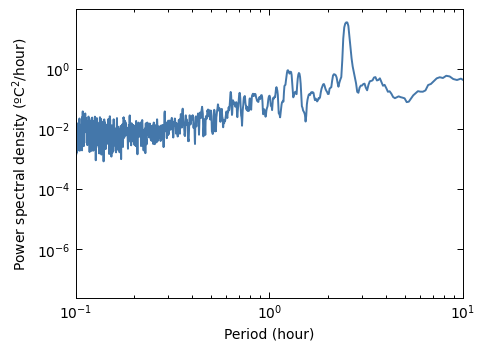

In [18]:
dt = 5/60/60
window_time = 1024
n_smooth = 10
units = 'hour'
freqs, psd = windowed_spectrum(temp[8], dt, window_time, n_smooth)
plot_spectrum(freqs, psd, 'hour', lims=(10**-1, 10))

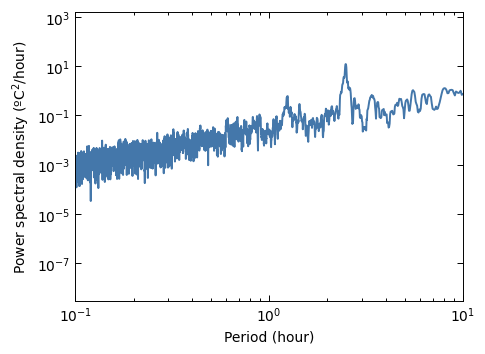

In [170]:
freqs, power, psd = spectrum(temp[10], dt, n_smooth)
plot_spectrum(freqs, psd, 'hour', lims=(10**-1, 10))